In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math, copy
from google.colab import files
%matplotlib inline

uploaded = files.upload()

Saving ex2data2.txt to ex2data2.txt


### Problem Statement

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests.
- From these two tests, you would like to determine whether the microchips should be accepted or rejected.
- To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

In [2]:
data = np.loadtxt("ex2data2.txt", delimiter=",")

X_train = data[:, :2]
y_train = data[:, 2]

In [3]:
# print X_train
print("X_train:", X_train[:5])
print("Type of X_train:",type(X_train))

X_train: [[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]
 [-0.21371   0.69225 ]
 [-0.375     0.50219 ]
 [-0.51325   0.46564 ]]
Type of X_train: <class 'numpy.ndarray'>


In [4]:
# print y_train
print("y_train:", y_train[:5])
print("Type of y_train:",type(y_train))

y_train: [1. 1. 1. 1. 1.]
Type of y_train: <class 'numpy.ndarray'>


In [5]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (118, 2)
The shape of y_train is: (118,)
We have m = 118 training examples


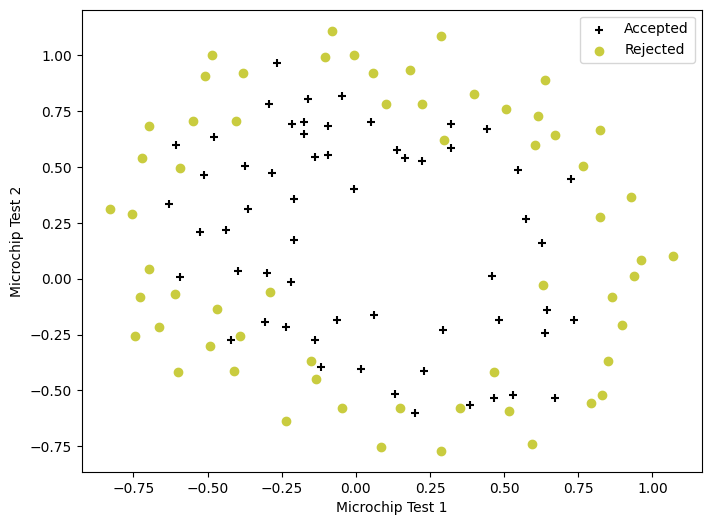

In [6]:
# Separate accepted and not accepted students
accepted = data[y_train == 1]
rejected = data[y_train == 0]

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(accepted[:, 0], accepted[:, 1], marker='+', color='black', label="Accepted")
plt.scatter(rejected[:, 0], rejected[:, 1], marker='o', color='#C9CC3F', label="Rejected")

# Labels and legend
plt.xlabel("Microchip Test 1")
plt.ylabel("Microchip Test 2")
plt.legend()
plt.show()

*   The dataset cannot be separated into positive and negative examples by a straight-line through the plot.

*   Therefore, a straight forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.



###Feature mapping

One way to fit the data better is to create more features from each data point. In the provided function `map_feature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$\mathrm{map\_feature}(x) =
\left[\begin{array}{c}
x_1\\
x_2\\
x_1^2\\
x_1 x_2\\
x_2^2\\
x_1^3\\
\vdots\\
x_1 x_2^5\\
x_2^6\end{array}\right]$$

In [7]:
def map_feature(X1, X2):
    """
    Feature mapping function to polynomial features
    """
    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)
    degree = 6
    out = []
    for i in range(1, degree+1):
        for j in range(i + 1):
            out.append((X1**(i-j) * (X2**j)))
    return np.stack(out, axis=1)

In [8]:
print("Original shape of data:", X_train.shape)

mapped_X =  map_feature(X_train[:, 0], X_train[:, 1])
print("Shape after feature mapping:", mapped_X.shape)

Original shape of data: (118, 2)
Shape after feature mapping: (118, 27)


In [9]:
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", mapped_X[0])

X_train[0]: [0.051267 0.69956 ]
mapped X_train[0]: [5.12670000e-02 6.99560000e-01 2.62830529e-03 3.58643425e-02
 4.89384194e-01 1.34745327e-04 1.83865725e-03 2.50892595e-02
 3.42353606e-01 6.90798869e-06 9.42624411e-05 1.28625106e-03
 1.75514423e-02 2.39496889e-01 3.54151856e-07 4.83255257e-06
 6.59422333e-05 8.99809795e-04 1.22782870e-02 1.67542444e-01
 1.81563032e-08 2.47750473e-07 3.38066048e-06 4.61305487e-05
 6.29470940e-04 8.58939846e-03 1.17205992e-01]




*   While the feature mapping allows us to build a more expressive classifier, it is also more susceptible to overfitting.
*   Regularized Logistic Regression can help combat the overfitting problem.



The formula for a sigmoid function is as follows -  

$g(z) = \frac{1}{1+e^{-z}}\tag{1}$

In [10]:
def sigmoid(z):

    g = 1 / (1 + np.exp(-z))

    return g

###Cost function for regularized logistic regression

The Cost Function for  regularized logistic regression is defined as:
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2  \tag{2}$$

The difference is the regularization term, which is $$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$
Note that the $b$ parameter is not regularized.

In [11]:
def compute_cost(X, y, w, b, lambda_ = 1):

    m, n = X.shape
    loss_sum = 0
    reg_cost = 0.

    for i in range(m):

        z_wb = 0
        for j in range(n):

            z_wb_ij = w[j] * X[i][j]
            z_wb += z_wb_ij

        z_wb += b
        f_wb = sigmoid(z_wb)

        loss = (-y[i] * np.log(f_wb)) - (1 - y[i]) * np.log(1 - f_wb)

        loss_sum += loss

    total_cost = (1 / m) * loss_sum
    for j in range(n):

        reg_cost_j = w[j] ** 2
        reg_cost += reg_cost_j

    reg_cost = (lambda_/(2 * m)) * reg_cost

    total_cost += reg_cost

    return total_cost

The Gradient is defined as:
$$\frac{\partial J(\mathbf{w},b)}{\partial b} = \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})  \tag{3}$$

$$\frac{\partial J(\mathbf{w},b)}{\partial w_j} = \left( \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} w_j  \quad\, \mbox{for $j=0...(n-1)$} \tag{4}$$

In [12]:
def compute_gradient(X, y, w, b, lambda_ = 1):

    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    for i in range(m):
        z_wb = 0
        for j in range(n):
            z_wb_ij = w[j] * X[i][j]
            z_wb += z_wb_ij
        z_wb += b
        f_wb = sigmoid(z_wb)

        dj_db_i = f_wb - y[i]
        dj_db += dj_db_i

        for j in range(n):
            dj_dw_ij = (f_wb - y[i]) * X[i][j]
            dj_dw[j] += dj_dw_ij

    dj_dw = dj_dw / m
    dj_db = dj_db / m

    for j in range(n):

        dj_dw_j_reg = (lambda_ / m) * w[j]

        dj_dw[j] = dj_dw[j] + dj_dw_j_reg

    return dj_db, dj_dw

Gradient Descent is defined as:
$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

In [15]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_):

    m = len(X)
    J_history = []
    w_history = []

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw
        b_in = b_in - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")

    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [17]:
# Initialize fitting parameters
np.random.seed(1)
initial_w = np.random.rand(mapped_X.shape[1])-0.5
initial_b = 1.

# Set regularization parameter lambda_ (you can try varying this)
lambda_ = 0.01

# Some gradient descent settings
iterations = 10000
alpha = 0.01

w,b, J_history,_ = gradient_descent(mapped_X, y_train, initial_w, initial_b,
                                    compute_cost, compute_gradient,
                                    alpha, iterations, lambda_)

Iteration    0: Cost     0.72   
Iteration 1000: Cost     0.59   
Iteration 2000: Cost     0.56   
Iteration 3000: Cost     0.53   
Iteration 4000: Cost     0.51   
Iteration 5000: Cost     0.50   
Iteration 6000: Cost     0.48   
Iteration 7000: Cost     0.47   
Iteration 8000: Cost     0.46   
Iteration 9000: Cost     0.45   
Iteration 9999: Cost     0.45   


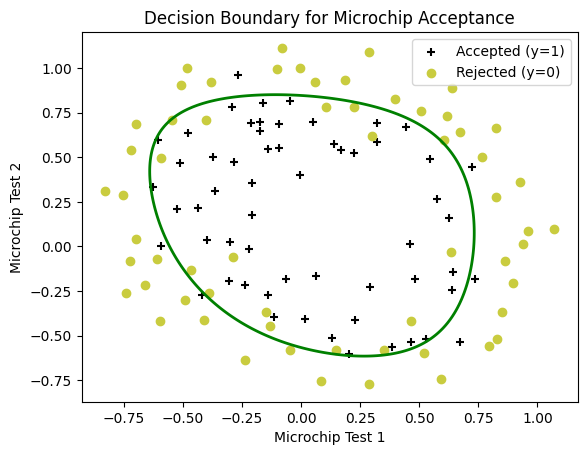

In [21]:
# Function to plot the decision boundary
def plot_decision_boundary(X, y, w, b):
    # Create a grid of points over the feature space
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Map the grid points to the feature space
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    mapped_grid_points = map_feature(grid_points[:, 0], grid_points[:, 1])

    # Predict the class for each point in the grid
    Z = np.dot(mapped_grid_points, w) + b
    Z = sigmoid(Z)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contour(xx, yy, Z, levels=[0.5], colors='green', linewidths=2)

    # Plot the data points
    accepted = X[y == 1]
    rejected = X[y == 0]
    plt.scatter(accepted[:, 0], accepted[:, 1], marker='+', color='black', label="Accepted (y=1)")
    plt.scatter(rejected[:, 0], rejected[:, 1], marker='o', color='#C9CC3F', label="Rejected (y=0)")

    # Labels and legend
    plt.xlabel("Microchip Test 1")
    plt.ylabel("Microchip Test 2")
    plt.title("Decision Boundary for Microchip Acceptance")
    plt.legend()
    plt.show()

# Plot the decision boundary
plot_decision_boundary(X_train, y_train, w, b)

In [24]:
def predict(X, w, b):

    # number of training examples
    m, n = X.shape
    p = np.zeros(m)

    # Loop over each example
    for i in range(m):
        z_wb = 0
        # Loop over each feature
        for j in range(n):
            # Add the corresponding term to z_wb
            z_wb_ij = w[j] * X[i][j]
            z_wb += z_wb_ij

        # Add bias term
        z_wb += b

        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        p[i] = f_wb >= 0.5

    return p

In [25]:
# Test your predict code
np.random.seed(1)
tmp_w = np.random.randn(2)
tmp_b = 0.3

tmp_X2 = np.array([
    [0.70, -0.85],
    [-1.30, 0.00],
    [0.25, 0.80],
    [-0.60, -1.10],
    [1.20, 1.00],
    [-0.50, 1.30],
    [0.90, -0.50],
    [-1.00, -0.80]
])

tmp_p = predict(tmp_X2, tmp_w, tmp_b)
print(f'Output of predict: shape {tmp_p.shape}, value {tmp_p}')

Output of predict: shape (8,), value [1. 0. 1. 0. 1. 0. 1. 0.]


In [26]:
#Compute accuracy on the training set
p = predict(mapped_X, w, b)

print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 82.203390
